# DISTRIBUTED HBV MODEL

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

#Working with masked array
import numpy.ma as ma
import math

In [2]:
import xarray as xr
import rasterio
import rioxarray
#Projecting the files
import cartopy.crs as ccrs  # projection

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

In [ ]:
import xesmf as xe    #For regridding climate data

In [5]:
# Cliping netcdf file

from shapely.geometry import mapping
import geopandas as gpd  #for reading the shapefile

In [7]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [ ]:
#Libraries for linear regression 
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import r2_score # measure the model performance

import piecewise_regression #Piecewise linear regression
from permetrics.regression import RegressionMetric

In [4]:
import networkx as nx

## Calibration Metrics

In [ ]:
#Calibration Nash Sutcliffe R2
def NSE(obs, sim):
    obs_arr = np.array(obs)
    sim_arr= np.array(sim)
    obs_mean = np.nanmean(obs_arr)
    
    R2= 1- np.nansum((obs_arr-sim_arr)**2)/np.nansum ((obs_arr-obs_mean)**2)

    return R2

def KGE(obs, sim): #Kling Gupta Efficiency
    obs_arr = np.array(obs)
    sim_arr= np.array(sim)
    evaluator = RegressionMetric(obs_arr, sim_arr)
    KGE= evaluator.KGE(multi_output="raw_values")

    return KGE

In [ ]:
## Read the observed discharges 
df_q= pd.read_excel(r"path\Discharge series.xlsx", index_col=0,
                   parse_dates= True)

## Reading DEM file and Sub-basin shapefiles

In [ ]:
# Reading Dem for oulu catchment 
dem= xr.open_dataset(r"path\Dem.tif", engine="rasterio")

dem= dem.rename({'band_data': 'elevtn'})

In [17]:
shp1= gpd.read_file(r"path\subcat1.shp")
shp2= gpd.read_file(r"path\subcat2.shp")
shp3= gpd.read_file(r"path\subcat3.shp")
shp4= gpd.read_file(r"path\subcat4.shp")

## Creating a function to define a subbasin dem:


In [24]:
"EPSG: 3067" # Finnish UTM coorinate system
"EPSG: 4326" # WGS1984 coordinate system

def clip(cm, shp): ## WGS 1984 Coordinate system
    cm = cm.rename({'lat':'y', 'lon':'x'}) # Specifiying the coordinate system
    cm.rio.write_crs("EPSG:4326",inplace= True)
    
    cm_fin= cm.rio.clip(shp.geometry.apply(mapping), shp.crs, all_touched= True, drop= True)
    #cm_fin= cm.rio.clip(shp.geometry.apply(mapping), shp.crs)
    
    cm_fin= cm_fin.rename({'y':'lat', 'x':'lon'})
    return cm_fin

def clip2(cm, shp):
    cm = cm.rename({'lat':'y', 'lon':'x'}) # Specifiying the coordinate system
    cm.rio.write_crs("EPSG:3067",inplace= True)
    
    #cm_fin= cm.rio.clip(shp.geometry.apply(mapping), shp.crs, all_touched= True, drop= True)
    cm_fin= cm.rio.clip(shp.geometry.apply(mapping), shp.crs)
    
    cm_fin= cm_fin.rename({'y':'lat', 'x':'lon'})
    return cm_fin


# HBV ROUTINE

In [ ]:
#readding input data
forcing = xr.open_dataset(r"path*.nc")

#Writng the coordinate system of the input data
forcing = forcing.rio.write_crs("EPSG: 3067")

#Slicing data 
forcing_20= forcing.sel(time=slice('1990-01-01', '2022-12-31'))
forcing_20

In [31]:
#Input data
ds_oul= forcing_20
#Creating arrays and masking them 
# Numpy array from

prec= np.array(ds_oul.pr)

temp= np.array(ds_oul.tas)

evap= np.array(ds_oul.ET0) 

### HBV Confined Parameters 

In [ ]:
Area = 1 #km/2
LA= 0.1 # Lake percentage in decimals

### HBV Model Parameters 
#### Need to be calibrated

In [34]:
# Correction for rain and temperature
Pcorr= 1 # Precipitatiot correction
Scorr = 1 # snow correction
Pgrad= float(0.5) # Precipitation lapse rate (%/ 100m)
Tgrad= 0.65  #Temperature lapse rate, wet day (ºC/100 m)
Tx = 0 # Threshold temperature for rain and snow 


#Model paramters for snow
Ts= -1 # 
CX=  3 # Degree day factor
CFR= 0.01
CPRO = 0.1

#Model parameters for soil
FC= 50 # Field Capacity 
LP = 0.8*FC # Threshold paramter to reduce evaporation
Beta = 2

#Upper tank
K1=  0.05 # Slow drainage 
K2= 0.45 #0.053# Fast drainage
UZ1 = 40 # Threshold for fast response 
PERC= 1 # Percolation

#Lower tank
KLZ=  0.01 #Drainage cofficient for lower basin 0.005


In [35]:
#creating empty array for the different states 
#Defining the snow routine

SN=  np.zeros_like(prec) #Dry snow pack
Prain= np.zeros_like(prec) # Precipitation as Rain
Psnow= np.zeros_like(prec) # Precipitation as snow
SMLT= np.zeros_like(prec) #Snow melt 
SR= np.zeros_like(prec) #Refreeze
ST=  np.zeros_like(prec)#Free water in the snow pack
INSOIL= np.zeros_like(prec) # To the soil routine
SW= np.zeros_like(prec) # Liquid water in snow

#Defining the soil routine 
dUZ= np.zeros_like(prec)
EA = np.zeros_like(prec)
SM= np.zeros_like(prec)


#Defining the upper tank and lower tank routines
#Upper tank
UZ= np.zeros_like(prec)
Q10 = np.zeros_like(prec)
Q11= np.zeros_like(prec)

LZ= np.zeros_like(prec)
QLZ = np.zeros_like(prec)
Qsim= np.zeros_like(prec)
Qin= np.zeros_like(prec)
Qdir = np.zeros_like(prec)

In [36]:
#Defining initial states
SN[0] = 50  # initial value for the simulated snow pack # Initial snow state
SW[0] = 20  # inital liquid water in the snow pack

SM[0]=  50.0 # initial soil moisture
UZ[0] = 20.0 # Initial upper storage
LZ[0] = 10.0 # Initial lower storage

## HBV Routine computations

In [37]:
for i in range(1, len(prec)):
    #np.where is used to compute multiple conditions
    
    #Getting rain and snow precipitation
    Prain[i]= np.where(temp[i]>Tx, prec[i]*Pcorr,0)
    Psnow[i]= np.where(temp[i]<=Tx, prec[i]*Scorr,0)
    
    #Snow routine
    # Snow melt equation 
    SMLT[i]= np.minimum(SN[i-1], np.maximum(0, CX*(temp[i]-Ts)))  #to ensure we dont melt more snow that available and also avoid negative melt

    # Snow refreeze
    SR[i]= np.minimum(SW[i-1], np.maximum(0,-1*CFR*CX*(temp[i]-Ts))) #Refreeze doesnt exceed the liquid water in the snow pack

    ST[i]= (SN[i-1]+Psnow[i]) *CPRO  # Computed free water limit in the snow pack

    #computing new states for the model
    SN[i] = SN[i-1]+ Psnow[i]-SMLT[i] + SR[i]  # Dry snow
    SW[i]= np.minimum(ST[i], SW[i-1]+ Prain[i]+SMLT[i]-SR[i])# Water content in snow
    
    
    #In Soil
    #All excess water from the snow is sent to the soil routine
    Qin[i]= np.maximum(0, (SW[i-1]+ Prain[i]+SMLT[i]-SR[i])-ST[i])

    #Direct runoff if the infilttration of soil is exceeded
    Qdir[i] = np.maximum(0, SM[i-1]+Qin[i]-FC)
    INSOIL[i]= Qin[i]-Qdir[i]
    
    #Soil routine 
    dUZ[i]= INSOIL[i]*(SM[i-1]/FC)**Beta  # water to the upper zone
    
    EA[i]= evap[i]*np.minimum(1, SM[i-1]/LP)  # Actual Evapouration
    SM[i] = SM[i-1]+ INSOIL[i]-dUZ[i]-EA[i] # Soil water content
    
    
    #Upper Zone routine
    #we add direct runoff to water infiltrated from the soil
    #NB if UZ <Perc; reduce perc according

    Q10[i]= np.minimum((UZ[i-1]+ dUZ[i]+Qdir[i]-np.minimum(PERC,UZ[i-1])), UZ1)*K1

    Q11[i]= np.maximum(0, (UZ[i-1]+ dUZ[i]+Qdir[i]-np.minimum(PERC,UZ[i-1]))-UZ1)*K2
    UZ[i] = UZ[i-1]+ dUZ[i]+Qdir[i]-np.minimum(PERC,UZ[i-1])- Q10[i]-Q11[i]

    #Lower zone routine
    QLZ[i] = KLZ*(LZ[i-1]+np.minimum(PERC,UZ[i-1]))+ LA*(prec[i]-evap[i])*KLZ
    
    
    #LZ[i]= LZ[i-1]+ np.minimum(PERC,UZ[i-1]) + (prec[i]-evap[i])*LA - QLZ[i]
    #LZ[i]= LZ[i-1]+ np.minimum(PERC,UZ[i-1])- QLZ[i] + LA*(prec[i]-evap[i])
    
    LZ[i]= np.maximum(0, (LZ[i-1]+ np.minimum(PERC,UZ[i-1])- QLZ[i] + LA*(prec[i]-evap[i])))
    
   
    #simulated discharge
    
    Qsim[i]= (Q10[i]+Q11[i]+ QLZ[i])*(Area*10**3)/(86400)
    

In [41]:
# Extracting coordinates 
lat= ds_oul['lat'].to_numpy()
lon= ds_oul['lon'].to_numpy()
time= ds_oul['time'].to_numpy()

### From numpy array to xarray 

### Here create different variable outputs from the model routines 

In [42]:

# Simulated Discharges 
Qsim_dr= xr.DataArray(Qsim,
                      coords={'time':time, 'lat':lat, 'lon':lon},
                     dims=['time','lat', 'lon'])

# Snow distribution
Qsn_dr= xr.DataArray(SN,
                      coords={'time':time, 'lat':lat, 'lon':lon},
                     dims=['time','lat', 'lon'])


In [47]:
def spatial_agg(cm):
    weights = np.cos(np.deg2rad(cm.lat))
    weights.name= 'weights'
    cm_weighted= cm.weighted(weights)
    cm_agg = cm_weighted.mean(['lat','lon'])
    
    return cm_agg

##  Sub-catchment discharges

In [ ]:
# List of shapefiles and corresponding labels
shapefiles = [shp1, shp2, shp3, shp4]
labels = ["Subcat1", "Subcat2", "Subcat3","Subcat4" ]  # Adjust labels as needed

# Create a dictionary to store the results
Qsim = {}

# Loop through the shapefiles and apply the clip2 function
for i, shp in enumerate(shapefiles):
    label = labels[i] if i < len(labels) else f"Region_{i+1}"
    Qsim[label] = clip2(Qsim_dr, shp)

In [50]:
# 0R Getting  discharges 

Qsim1= clip2(Qsim_dr, shp1) 
Qsim2= clip2(Qsim_dr, shp2)

Qsim3= clip2(Qsim_dr, shp3) 
Qsim4= clip2(Qsim_dr, shp4)

## Spatial aggregation and Subbasin dicharges
### To Data frame

In [55]:
#sub catchment discharge
def qsim(qsim_ds):
    q_arr= qsim_ds.to_numpy()
    q_arr2= ma.masked_invalid(q_arr)
    
    qsum= np.sum(q_arr2,axis=(1,2))
    df_q= pd.DataFrame(qsum)
    
    df_q= pd.DataFrame(qsum, index=time)
    df_q.rename(columns={0:'Qsim'}, inplace=True)
    
    df_q= df_q.rename_axis('Date')

    #df_q.index= time
    
    return df_q

In [56]:
df_q1= qsim(Qsim1) #Subcat 1
df_q2= qsim(Qsim2) #Subcat 2

df_q3= qsim(Qsim3) #Subcat 3
df_q4= qsim(Qsim4) #Subcat 4

# Concatenating DataFrames while handling similar column names
df_subcat = pd.concat([df_q1, df_q3,df_q4], axis=1, 
                    keys=['Subcat1','Subcat2','Subcat3','Subcat4'])

# Flatten MultiIndex columns if necessary
df_subcat.columns = subcat.columns.droplevel(1)


# Flatten MultiIndex columns if necessary
df_subcat.head()

# River routing

### Illustartion to the river network

-Both Subcat1 and Subcat 2 flow into 3, which flows to 4

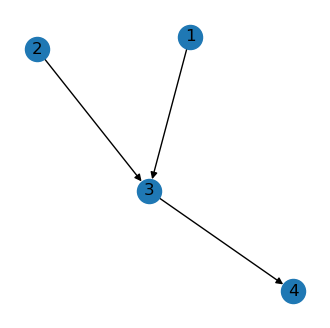

In [5]:

DG= nx.DiGraph()
DG.add_edge(1, 3)   # adds the nodes in order 2, 1
DG.add_edge(2, 3)
DG.add_edge(3, 4)
fig, ax= plt.subplots(figsize=(4,4))
nx.draw(DG, ax= ax, with_labels=True)

## Kinewatic wave routing 

**A kinematic wave** is an approximation to the one-dimensional St.Venant equations 
(https://en.wikipedia.org/wiki/Shallow_water_equations ) that is used quite a lot in hydrology to 
describe overland flow in distributed and semi-distributed models. The simplified equations can be 
described like this (assuming lateral flow = 0): 

$$
Q_{i+1}^{j+1} =
\frac{\left[\frac{\Delta t}{\Delta x} \, Q_i^{j+1} \;+\; \alpha \,\beta \,\Bigl(\frac{Q_i^j + Q_{i+1}^j}{2}\Bigr)^{\beta - 1}\right]}
{\left[\frac{\Delta t}{\Delta x} \;+\; \alpha \,\beta \,\Bigl(\frac{Q_i^j + Q_{i+1}^j}{2}\Bigr)^{\beta - 1}\right]}
$$

where **a**, **b** are coefficients, 
**Q** is the discharge,

**i** is the space dimension and **j** is the time dimension. 
The two coefficients are derived from the Manning equation and has the form: 

**B** – channel width, 

**M** – Mannings number,

**S** – channel slope

#### Simulated sub basin
- df_subcat

#### File containing the coordinates in UTM and dwosntreeam draining basin 
- df_coordinates

In [ ]:
#Getting the elevation at sub-basin outlet
coord_arr= df_coordinates.to_numpy()

coord_dem =[]
for i in range(len(coord_arr)):
    x= coord_arr[i,0]  # X-coordinate
    y= coord_arr[i,1]  # y-coordinate
    dem_coord= float(dem_oul['elevtn'][0].sel(x= x, y= y, method='nearest').to_numpy())
    coord_dem.append(dem_coord)
    


In [ ]:
#Getting the distance river stretches
distance_arr= []
for i in range(len(coord_arr)):
    index= coord_arr[i,2]-1
    distance = float(np.sqrt((coord_arr[i,0]-coord_arr[index,0])**2+(coord_arr[i,1]-coord_arr[index,1])**2))
    distance_arr.append(distance)


In [ ]:
# Routing paramters 
M= 32 # Mannings M
B = 40 # Width in m
time_step = 60*60*24 # Daily time step
beta= 0.6

In [31]:
df_coordinates['DEM']= coord_dem
df_coordinates['Distance']= distance_arr


df_coordinates['Slope']= df_coordinates['DEM']/df_coordinates['Distance']
df_coordinates['alpha']= (B**(2/3)/(M*df_coordinates['Slope']**0.5))**0.6
df_coordinates['delta']= time_step/df_coordinates['Distance']

## River flow Routing 

In [ ]:
def downstream_arr(arr):
    arr2= np.zeros(len(arr))
    
    #Creating a ownstream array at j
    arr21= np.column_stack((arr,arr2))
    arr21[0,1]= arr21[0,0]
    return arr21

### Create downstream arrays

In [ ]:
## Coordinate_array 
Coord_arr= np.array(df_coordinates)

# Subcat array 
Q_subcat= np.array(df_subcat)

## Create a new array of routed dowsntream flows 
Q_routed= Q_subcat.copy()
Q_routed.shape

In [ ]:
'''
## Routing flow from Subbasin2 and Subbasin 3 and adding local influx at Subcat 3
'''
#subbasin 1
arr_sub1= Q_routed[:,0]
arr_sub12= downstream_arr(arr_sub1)



#subbasin 2
arr_sub2= Q_routed[:,1]
arr_sub22= downstream_arr(arr_sub2)

#Routing flow 

for i in range(1, len(arr_sub1)):
    #
    # From subbasin1 
    arr_sub12[i,1] = (
        (Coord_arr[0, 8]* arr_sub12[i, 0] + Coord_arr[0, 7] * beta * arr_sub12[i-1,1] *
        ((arr_sub12[i-1,1] + arr_sub12[i,0]+eps) / 2)**(beta-1)) /
        (Coord_arr[0, 8] + Coord_arr[0, 7] *beta*
        ((arr_sub12[i-1,1] + arr_sub12[i,0]+eps) / 2)**(beta-1)))
    
    #From Subbasin2
    arr_sub22[i,1] = (
        (Coord_arr[1, 8]* arr_sub22[i, 0] + Coord_arr[1, 7] * beta * arr_sub22[i-1,1] *
        ((arr_sub22[i-1,1] + arr_sub22[i,0]+eps) / 2)**(beta-1)) /
        (Coord_arr[1, 8] + Coord_arr[1, 7] *beta*
        ((arr_sub22[i-1,1] + arr_sub22[i,0]+eps) / 2)**(beta-1)))
    
    Q_routed[i,2]+= arr_sub12[i,1]+ arr_sub22[i,1]  # Discharges at subbasin 3
    
    
    
'''Routing from Subbasin 3 to Subbasin 4 and adding local influx '''
#subbasin 3

arr_sub3= Q_routed[:,3]
arr_sub32= downstream_arr(arr_sub3)


for i in range(1, len(arr_sub3)):
    
    #From Subbasin3 and adding local influx at 4
    arr_sub32[i,1] = (
        (Coord_arr[2, 8]* arr_sub32[i, 0] + Coord_arr[2, 7] * beta * arr_sub32[i-1,1] *
        ((arr_sub32[i-1,1] + arr_sub32[i,0]+eps) / 2)**(beta-1)) /
        (Coord_arr[2, 8] + Coord_arr[2, 7] *beta*
        ((arr_sub32[i-1,1] + arr_sub32[i,0]+eps) / 2)**(beta-1)))
    
    Q_routed[i,3]+=  arr_sub32[i,1]  # Discharges at subbasin 3
    

### Converting arrays to dataframes

In [ ]:
df_routed= pd.DataFrame(Q_routed, columns =df_subcat.columns.tolist(), index= df_subcat.index)
df_routed.head()